In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import os
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt


C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
name = 'fashion_BIGAN'
if not os.path.exists("saved_model/"+name):
        os.mkdir("saved_model/"+name)
if not os.path.exists("images/"+name):
        os.mkdir("images/"+name)

In [3]:
# Download the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('X_train', X_train.shape,'y_train', y_train.shape)
print('X_test', X_test.shape,'y_test', y_test.shape)

X_train (60000, 28, 28) y_train (60000,)
X_test (10000, 28, 28) y_test (10000,)


In [4]:
input_classes = pd.Series(y_train).nunique()
input_classes

10

In [5]:
# Training Labels are evenly distributed
Train_label_count = pd.Series(y_train).value_counts()
Train_label_count

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
# Test Labels are evenly distributed
Test_label_count = pd.Series(y_test).value_counts()
Test_label_count

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [7]:
#label dictionary from documentation
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [8]:
X_train[1].shape

(28, 28)

In [9]:
#input dimensions
input_rows = X_train[1][0]
input_cols = X_train[1][1]
input_channels = 1

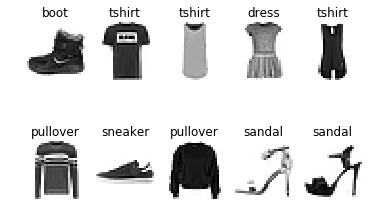

In [10]:
# plot images from the train dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray_r')
    a.set_title(label_dict[y_train[i]])

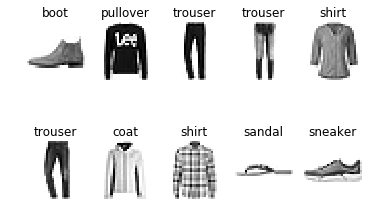

In [11]:
# plot images from the test dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_test[i], cmap='gray_r')
    a.set_title(label_dict[y_test[i]])

In [12]:
class BIGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the encoder
        self.encoder = self.build_encoder()

        # The part of the bigan that trains the discriminator and encoder
        self.discriminator.trainable = False

        # Generate image from sampled noise
        z = Input(shape=(self.latent_dim, ))
        img_ = self.generator(z)

        # Encode image
        img = Input(shape=self.img_shape)
        z_ = self.encoder(img)

        # Latent -> img is fake, and img -> latent is valid
        fake = self.discriminator([z, img_])
        valid = self.discriminator([z_, img])

        # Set up and compile the combined model
        # Trains generator to fool the discriminator
        self.bigan_generator = Model([z, img], [fake, valid])
        self.bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)


    def build_encoder(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.latent_dim))

        model.summary()

        img = Input(shape=self.img_shape)
        z = model(img)

        return Model(img, z)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        z = Input(shape=(self.latent_dim,))
        gen_img = model(z)

        return Model(z, gen_img)

    def build_discriminator(self):

        z = Input(shape=(self.latent_dim, ))
        img = Input(shape=self.img_shape)
        d_in = concatenate([z, Flatten()(img)])

        model = Dense(1024)(d_in)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        validity = Dense(1, activation="sigmoid")(model)

        return Model([z, img], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):


            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Sample noise and generate img
            z = np.random.normal(size=(batch_size, self.latent_dim))
            imgs_ = self.generator.predict(z)

            # Select a random batch of images and encode
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            z_ = self.encoder.predict(imgs)

            # Train the discriminator (img -> z is valid, z -> img is fake)
            d_loss_real = self.discriminator.train_on_batch([z_, imgs], valid)
            d_loss_fake = self.discriminator.train_on_batch([z, imgs_], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (z -> img is valid and img -> z is is invalid)
            g_loss = self.bigan_generator.train_on_batch([z, imgs], [valid, fake])

            # Plot the progress
            #print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_interval(epoch)
                self.save_model()
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

    def sample_interval(self, epoch):
        r, c = 5, 5
        z = np.random.normal(size=(25, self.latent_dim))
        gen_imgs = self.generator.predict(z)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/"+name+"/_%d.png" % epoch)
        plt.imread("images/"+name+"/_%d.png" % epoch)
        plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/"+name+"/%s.json" % model_name
            weights_path = "saved_model/"+name+"/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])
        save(self.generator, "bigan_generator")
        save(self.discriminator, "bigan_discriminator")
        save(self.encoder, "bigan_encoder")
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               402192    
__________

C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


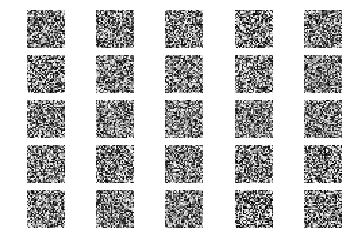

0 [D loss: 1.176604, acc: 19.53%] [G loss: 3.128314]


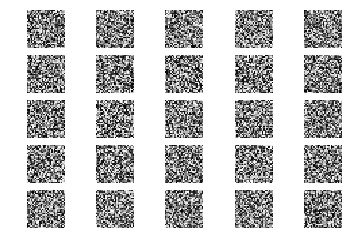

1 [D loss: 0.750259, acc: 55.47%] [G loss: 3.592946]


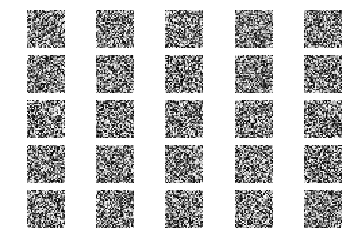

2 [D loss: 0.351778, acc: 84.77%] [G loss: 3.863534]


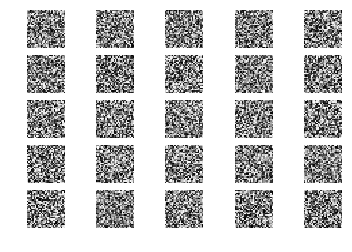

3 [D loss: 0.260489, acc: 93.75%] [G loss: 4.941170]


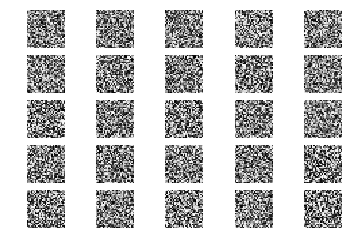

4 [D loss: 0.181151, acc: 96.88%] [G loss: 6.038336]


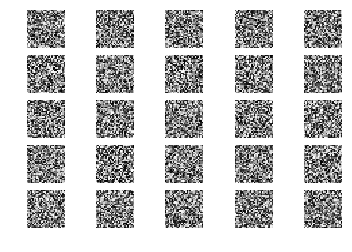

5 [D loss: 0.153328, acc: 98.44%] [G loss: 7.137030]


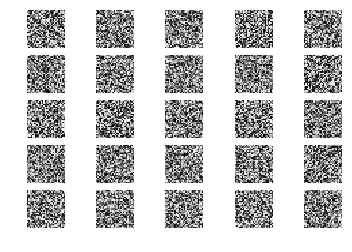

6 [D loss: 0.111381, acc: 98.05%] [G loss: 7.961243]


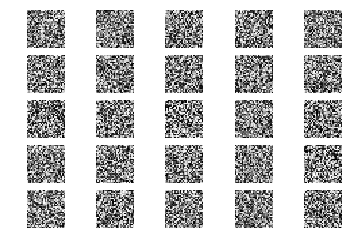

7 [D loss: 0.067311, acc: 99.61%] [G loss: 8.456785]


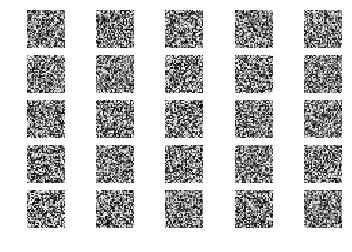

8 [D loss: 0.062659, acc: 99.61%] [G loss: 9.357657]


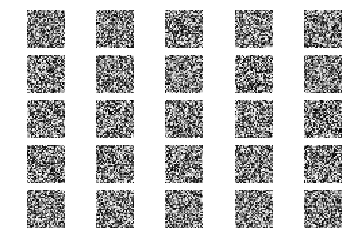

9 [D loss: 0.069530, acc: 99.22%] [G loss: 10.426361]


In [13]:
bigan = BIGAN()
bigan.train(epochs=10, batch_size=128, sample_interval=1)